In [1]:
import pandas as pd

from bengrn import BenGRN, FILEDIR

import numpy as np
import scanpy as sc
import os
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from grnndata import utils as grnutils
from matplotlib import pyplot as plt
from pyvis import network as pnx
import networkx as nx
import scipy.sparse
import gseapy as gp
from gseapy import dotplot

import seaborn as sns
import bionty as bt
from grnndata import read_h5ad

from scdataloader.utils import load_genes
import anndata as ad
from grnndata import from_adata_and_longform

%reload_ext autoreload
%autoreload 2

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


In [2]:
name = "B cell"

grn_m = read_h5ad(f"./data/grn_task4_mouse_{name}.h5ad")
grn_h = read_h5ad(f"./data/grn_task4_human_{name}.h5ad")

In [3]:
# between the two networks we have ~3000 genes in common over their 4000 genes
grn_m.var.index = grn_m.var.symbol.str.upper()
common = set(grn_h.var.index) & set(grn_m.var.index)
len(common)

1650

In [14]:
grn_h.grn.sum(0).sort_values(ascending=False).head(20)

symbol
GPR183     129.212936
UGT1A9      90.286057
TMSB4X      82.656120
RPL23       49.138138
JCHAIN      47.933247
MOCOS       44.518085
RPL15       38.902645
CSTB        38.207447
S100A5      38.182125
RGS2        36.185287
SLC47A2     35.361763
RPS6        32.497929
ITM2C       28.860186
BLOC1S3     28.255081
HLA-C       23.455450
HSPA6       23.279291
EEF1A1      22.035364
GPX1        21.385178
VASP        21.068890
RGS1        20.219160
dtype: float32

<Axes: xlabel='RF2-PPI_interaction_probability', ylabel='Count'>

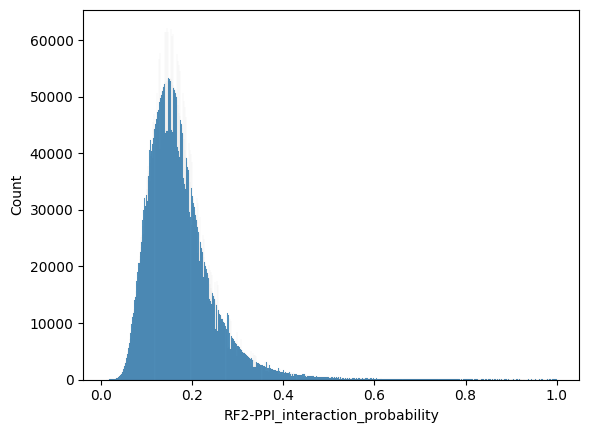

In [53]:
sns.histplot(res["RF2-PPI_interaction_probability"])

In [3]:
prot_to_gene = {
    i["uniprotkb_id"]: i["gene_symbol"] for k, i in bt.Protein.public().df().iterrows()
}

In [4]:
genes = []
for i in res.Pair:
    a, b = i.split("_")
    genes.append([prot_to_gene.get(a, ""), prot_to_gene.get(b, "")])

res[["geneA", "geneB"]] = genes

In [ ]:
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_inter = from_adata_and_longform(
    empty_adata,
    res.loc[:, ["geneA", "geneB", "RF2-PPI_interaction_probability"]],
    is_directed=False,
    has_weight=True,
)

Created empty AnnData with 70611 genes


/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
del res

In [7]:
gt_inter.varp["GRN"] = gt_inter.varp["GRN"].toarray()

In [8]:
gt_inter.varp["GRN"][gt_inter.varp["GRN"] <= 0.7] = 0

In [ ]:
gt_inter.var.set_index("ensembl_id", inplace=True, drop=False)

In [21]:
gt_inter.write_h5ad("gt_inter.h5ad")

In [27]:
gt_inter = read_h5ad("gt_inter.h5ad")

In [28]:
gt_inter.var.set_index("symbol", inplace=True, drop=False)

In [ ]:
gt_inter

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


precision:  0.0007636248490153184 
recall:  1.0 
random precision: 0.0007637647070462735


 98%|█████████▊| 126/128 [00:07<00:00, 21.37it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:07<00:00, 16.94it/s]


Average Precision (AP):  0.0008291120987167978
Area Under Precision-Recall Curve (AUPRC):  0.0008279850478692889
EPR: 1.2719919913957423


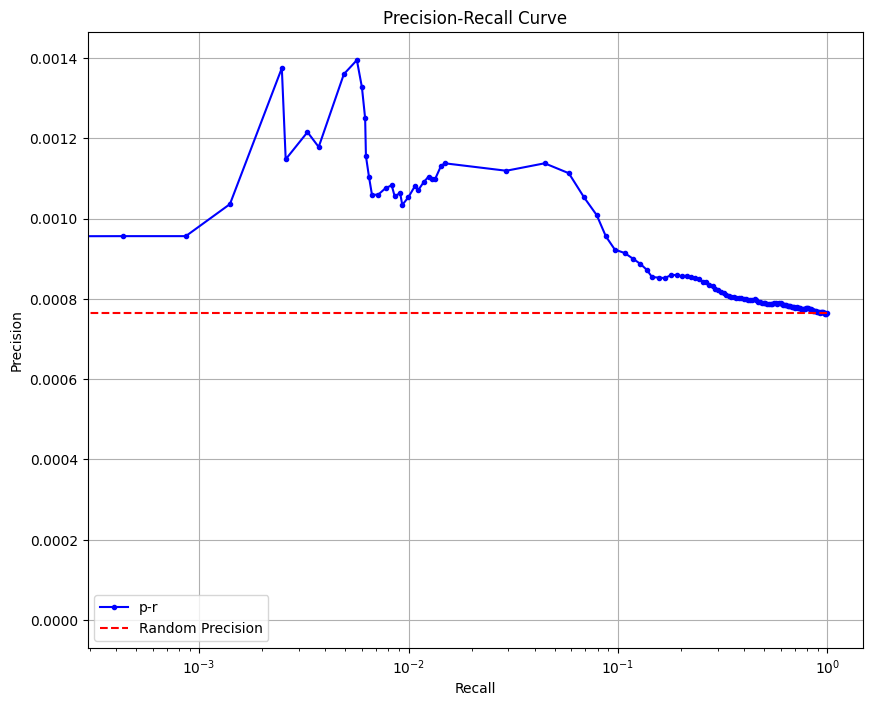

{'precision': np.float64(0.0007636248490153184),
 'recall': np.float64(1.0),
 'rand_precision': np.float64(0.0007637647070462735),
 'auprc': np.float64(0.0008279850478692889),
 'ap': np.float64(0.0008291120987167978),
 'epr': np.float64(1.2719919913957423),
 'odd_ratio': np.float64(1.27252124437533)}

In [9]:
BenGRN(grn_h).compare_to(gt_inter)

In [ ]:
K = 20
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

In [17]:
gt_inter.var

,uid,symbol,biotype,organism_id,branch_id,mt,ribo,hb,organism
symbol,,,,,,,,,
TSPAN6,1uTi9dROoaN5,TSPAN6,protein_coding,105,1,False,False,False,NCBITaxon:9606
TNMD,2FhduD7Z97Uv,TNMD,protein_coding,105,1,False,False,False,NCBITaxon:9606
DPM1,4eC1wUNJAO2s,DPM1,protein_coding,105,1,False,False,False,NCBITaxon:9606
SCYL3,5Zug63FETk4p,SCYL3,protein_coding,105,1,False,False,False,NCBITaxon:9606
FIRRM,3wEqb6eOTZzC,FIRRM,protein_coding,105,1,False,False,False,NCBITaxon:9606
...,...,...,...,...,...,...,...,...,...
NaN,42lwxhgTHxaN,NaN,lncRNA,105,1,False,False,False,NCBITaxon:9606
LINC00970,12nPu7ce9hLZ,LINC00970,lncRNA,105,1,False,False,False,NCBITaxon:9606
NaN,2DLKDsGV0zX9,NaN,lncRNA,105,1,False,False,False,NCBITaxon:9606


In [26]:
gt_inter

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'nan-22293', 'nan-22294', 'nan-22295', 'nan-22296', 'SLC25A3P1-1',
       'nan-22297', 'LINC00970-1', 'nan-22298', 'nan-22299', 'ORAI1-1'],
      dtype='object', name='symbol', length=70611)

In [29]:
gt_inter.var.index = make_index_unique(gt_inter.var.index.astype(str))

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/utils.py:268: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


In [30]:
gt_inter = gt_inter[:, subgrn_h.columns]

In [ ]:
gt_inter.varp["GRN"].mean()

np.float64(0.035750241857714804)

In [ ]:
K = 20
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
gt_inter.varp["GRN"][subgrn_h].mean()

np.float64(0.03602317168827906)

In [ ]:
K = 10
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
gt_inter.varp["GRN"][subgrn_h].mean()

np.float64(0.035895949970245276)

In [ ]:
K = 5
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
gt_inter.varp["GRN"][subgrn_h].mean()

np.float64(0.044568367227985524)

In [ ]:
K = 4
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
gt_inter.varp["GRN"][subgrn_h].mean()

np.float64(0.04479226580367913)

In [ ]:
K = 1
subgrn_h = grn_h.grn.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
gt_inter.varp["GRN"][subgrn_h].mean()

np.float64(0.043387741656614395)

In [ ]:
gt_inter.varp["GRN"].mean()

np.float64(0.035750241857714804)

In [ ]:
gt_inter.varp["GRN"][grn_h.grn > 0.0001].mean()

np.float64(0.032879091356477)

In [ ]:
gt_inter.varp["GRN"][grn_h.grn > 0.001].mean()

np.float64(0.02952335576222379)

In [ ]:
gt_inter.varp["GRN"][grn_h.grn > 0.01].mean()

np.float64(0.04709743833948982)

In [ ]:
gt_inter.varp["GRN"][grn_h.grn > 0.03].mean()

np.float64(0.052716539795114266)

In [61]:
res[(res.geneA == "TMSB10")]  # & (res.geneB=='TMSB4X')]


def isin(geneA, geneB=None):
    if geneB is None:
        loc = (res.geneA == geneA) | (res.geneB == geneA)
    else:
        loc = ((res.geneA == geneA) & (res.geneB == geneB)) | (
            (res.geneA == geneB) & (res.geneB == geneA)
        )
    if loc.any():
        return res[loc]
    else:
        return "?"

In [ ]:
FLT1, B2M

In [ ]:
res[res["RF2-PPI_interaction_probability"] >= 0.33]

,Pair,RF2-PPI_interaction_probability,Source,geneA,geneB
191,Q15652_Q9UIF9,0.3406,"STR,DNS",JMJD1C,BAZ2A
411,Q12873_Q5T5U3,0.4200,DNS,CHD3,ARHGAP21
415,Q5T5U3_Q92673,0.5070,DNS,ARHGAP21,SORL1
501,O14529_Q9Y4R8,0.3381,DNS,CUX2,TELO2
738,O14529_P51531,0.4722,DNS,CUX2,SMARCA2
...,...,...,...,...,...
9999799,Q9UK59_Q9Y2U9,0.3909,DNS,DBR1,KLHDC2
9999800,P49662_Q8TCU3,0.4194,DNS,CASP4,SLC7A13
9999807,Q12884_Q6P5S7,0.3464,DNS,FAP,RNASEK
9999835,Q15813_Q8TB92,0.4849,DNS,TBCE,HMGCLL1


In [ ]:
gt_inter.varp["GRN"].mean()

np.float64(0.0022255889798024806)

In [ ]:
grn_h.varp["GRN"]

array([[1.1972245e-04, 6.5625245e-05, 7.3266245e-05, ..., 2.4231676e-04,
        9.3620787e-05, 4.4131358e-04],
       [1.2109504e-04, 6.6581444e-05, 7.4116113e-05, ..., 2.0672192e-04,
        1.0557933e-04, 4.0692478e-04],
       [1.2203633e-04, 6.8528112e-05, 7.6273587e-05, ..., 2.2097914e-04,
        1.0816239e-04, 4.6247177e-04],
       ...,
       [1.4324990e-04, 7.7480378e-05, 9.2483897e-05, ..., 2.8515497e-04,
        1.1235714e-04, 4.7008725e-04],
       [1.2377625e-04, 7.1777191e-05, 8.1032405e-05, ..., 2.4810573e-04,
        1.3011643e-04, 5.5706286e-04],
       [1.3625128e-04, 7.2545008e-05, 7.6203098e-05, ..., 5.4424687e-04,
        1.2050326e-04, 1.4498582e-03]], shape=(4974, 4974), dtype=float32)

In [ ]:
gt_inter.varp['GRN'][].mean()

In [62]:
isin("B2M")

,Pair,RF2-PPI_interaction_probability,Source,geneA,geneB
6585998,P61769_Q01955,0.16970,DNS,B2M,COL4A3
6946397,P61769_Q9UMD9,0.09436,DNS,B2M,COL17A1
7384402,P61769_Q9UGM3,0.13300,DNS,B2M,DMBT1
7453220,P61769_Q9Y6C2,0.09064,DNS,B2M,EMILIN1
7773071,P39059_P61769,0.07135,DNS,COL15A1,B2M
8104457,A4D0S4_P61769,0.12540,DNS,LAMB4,B2M
8387716,P61769_Q9NR16,0.14390,DNS,B2M,CD163L1
8678958,P61769_Q6IE37,0.10565,DNS,B2M,OVOS1
8684130,P61769_Q8TE58,0.14170,DNS,B2M,ADAMTS15
8695581,P61769_Q6ZWJ8,0.11615,DNS,B2M,KCP


In [3]:
# extracting PPI data from "computing the human interactome"
humaninter = pd.read_csv(
    "http://prodata.swmed.edu/humanPPI/bulk_download/GoodPairs.txt",
    sep="\t",
    skiprows=0,
)

In [ ]:
h = [
    "ACTB",
    "B2M",
    "TMSB4X",
    "TMSB10",
    "CD83",
    "CD52",
    "RPL41",
    "RPL3",
    "RPL10",
    "RPS6",
    "RPS27A",
    "FTL",
    "FTH1",
    "MEF2C",
    "JUNB",
    "JCHAIN",
    "CREM",
    "FCER1G",
    "TOP2A",
    "CRIP1",
    "PPP1R15A",
    "MS4A1",
    "PPIA",
    "RGS1",
    "GPR183",
    "GPX1",
    "ITM2C",
    "OGT",
    "UBE2S",
    "IFITM1",
    "CST3",
    "PTMA",
]

In [ ]:
FTL, JCHAIN

In [ ]:
group = [  # unknown "PP1R",
    "RPS",
    "TMS",
    "TOP",
    "FT",
]

In [40]:
humaninter[humaninter["Name1"].str.startswith(group[4])]

,Protein1,Protein2,Name1,Name2,confidence_level,RFprob,AFprob,CFprob,AFMprob,PDBtemp,...,Disease2,Process1,Process2,Function1,Function2,confDBs,allDBs,Exact_templates,Ortho_templates,Homo_templates
6155,Q8IY81,Q9Y3U8,FTSJ3,RPL36,high,0.1543,0.99400,0.9966,0.9873,exact,...,none,"Ribosome biogenesis,rRNA processing",none,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,Large ribosomal subunit protein eL36,"BIOGRID,STRING","BIOGRID,STRING","8fkr,8fkx,8fkp,8fkt,8fkw,8fku,8fks,8fkv,8fky,8fkq",none,"8i9z,7r6q,7nac,8i9w,8esq,8i9v,8esr,6elz,8i9y,8..."
7532,Q8IY81,Q9BXY0,FTSJ3,MAK16,moderate,0.2686,0.02425,0.1482,0.8560,none,...,none,"Ribosome biogenesis,rRNA processing",none,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,Protein MAK16 homolog,"BIOGRID,STRING","BIOGRID,STRING",none,none,none
9664,Q8IY81,Q9UHA3,FTSJ3,RSL24D1,high,0.1617,0.99700,0.9990,0.9910,exact,...,none,"Ribosome biogenesis,rRNA processing",Ribosome biogenesis,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,Probable ribosome biogenesis protein RLP24,STRING,STRING,8ir1,7naf,"8etj,7u0h,8i9z,7nac,8etc,8esq,8ia0,6elz,6ylx,7..."
13270,P02792,Q8N4E7,FTL,FTMT,high,1.0000,0.99760,0.9985,0.9995,homolog,...,none,Iron storage,Iron storage,Ferritin light chain,"Ferritin, mitochondrial",none,STRING,none,none,"7dlb,8emq,5v5k,6ipo,1z4a,8pp2,6h6u,7x9z,8hhs,8..."
20879,Q8IY81,Q8WTT2,FTSJ3,NOC3L,high,0.8690,0.99200,0.9970,0.9966,exact,...,none,"Ribosome biogenesis,rRNA processing",none,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,Nucleolar complex protein 3 homolog,STRING,STRING,"8fkv,8fkx,8fkw,8fky",none,"8i9z,7nac,6em5,8i9w,8esq,8i9v,8esr,6elz,8i9y,7..."
27263,P02792,P02794,FTL,FTH1,high,0.9976,0.99600,0.9976,0.9995,homolog,...,none,Iron storage,Iron storage,Ferritin light chain,Ferritin heavy chain,"BIOGRID,STRING,UNIPROT","BIOGRID,STRING,UNIPROT",none,none,"7dlb,8emq,5v5k,6ipo,1z4a,8pp2,6h6u,7x9z,8hhs,8..."
27353,Q8IY81,Q9UGY1,FTSJ3,NOL12,high,0.9890,0.98600,0.9960,0.9970,homolog,...,none,"Ribosome biogenesis,rRNA processing",none,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,Nucleolar protein 12,STRING,"BIOGRID,STRING",none,none,"7naf,7nad,7nac"
28901,Q8IY81,Q9Y221,FTSJ3,NIP7,high,0.6180,0.60800,0.8770,0.7240,none,...,none,"Ribosome biogenesis,rRNA processing",Ribosome biogenesis,pre-rRNA 2'-O-ribose RNA methyltransferase FTSJ3,60S ribosome subunit biogenesis protein NIP7 h...,STRING,STRING,none,none,none


In [2]:
from scdataloader.utils import load_genes
import anndata as ad
import pandas as pd
import bionty as bt
from grnndata import from_adata_and_longform

genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_inter = from_adata_and_longform(empty_adata, humaninter.iloc[:, 2:4])

→ connected lamindb: jkobject/scprint_v2
Created empty AnnData with 70611 genes


NameError: name 'humaninter' is not defined

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


precision:  0.00022068066382930146 
recall:  1.0 
random precision: 0.0002207210815332995


 97%|█████████▋| 124/128 [00:03<00:00, 36.56it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 38.33it/s]


Average Precision (AP):  0.0002649449014974144
Area Under Precision-Recall Curve (AUPRC):  0.0002645800722596629
EPR: 1.3048977070016352


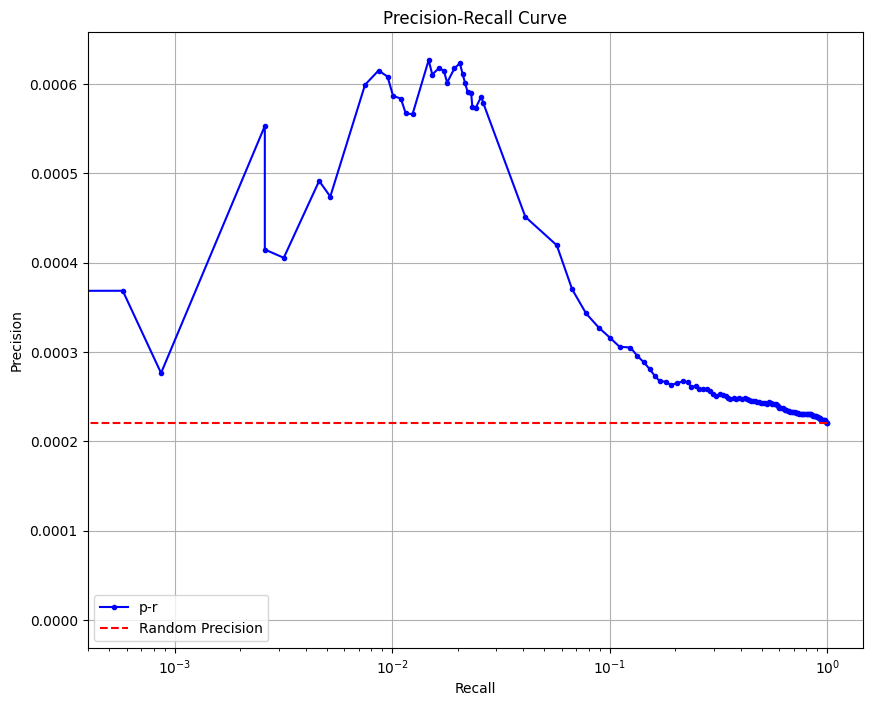

{'precision': np.float64(0.00022068066382930146),
 'recall': np.float64(1.0),
 'rand_precision': np.float64(0.0002207210815332995),
 'auprc': np.float64(0.0002645800722596629),
 'ap': np.float64(0.0002649449014974144),
 'epr': np.float64(1.3048977070016352),
 'odd_ratio': np.float64(1.3050734152285044)}

In [42]:
BenGRN(grn_h).compare_to(gt_inter)

In [ ]:
# gt_inter = gt_inter[:,gt_inter.var.index.isin(grn_h.var.index)]
gt_inter = gt_inter[:, gt_inter.grn.sum(0) + gt_inter.grn.sum(1) > 0]

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:107: UserWarning: Failed to slice GRN matrix. Resulting GRNAnnData will have grn=None.
  warnings.warn(


In [83]:
gt_inter

GRnnData object with n_obs × n_vars = 1 × 12214
    var: 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_id'
    varp: 'GRN'
    with a grn of 29052 elements

In [9]:
h1 = list(set(gt_inter.var.index) & set(h))
h2 = list(set(humaninter["Name2"]) & set(h))

NameError: name 'h' is not defined

In [ ]:
gt_inter.grn[gt_inter.grn.loc["MEF2C"] == 1]

symbol,TSPAN6,DPM1,SCYL3,CFH,FUCA2,GCLC,NFYA,NIPAL3,LAS1L,ENPP4,SEMA3F,ANKIB1,CYP51A1,KRIT1,RAD52,BAD,CD99,HS3ST1,WNT16,HECW1,MAD1L1,LASP1,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,CASP10,CFLAR,TFPI,NDUFAF7,RBM5,MTMR7,ARF5,SARM1,POLDIP2,AK2,FKBP4,KDM1A,RBM6,CAMKK1,VPS50,HSPB6,NDUFAB1,PDK4,ZMYND10,ARX,ST7,CDC27,SLC4A1,CALCR,HCCS,DVL2,SKAP2,SLC25A5,MCUB,POLR2J,DHX33,MEOX1,THSD7A,LIG3,RPAP3,ACSM3,CIAPIN1,ATOSB,COPZ2,PRKAR2B,MSL3,CREBBP,TSPOAP1,GCFC2,WDR54,IBTK,FBXL3,ITGAL,PDK2,ITGA3,LAMP2,ITGA2B,ASB4,GDE1,REX1BD,OSBPL7,TMEM98,YBX2,KRT33A,CACNG3,AP2B1,TAC1,ZNF263,CX3CL1,SPATA20,TNFRSF12A,MAP3K9,RALA,BAIAP2L1,KDM7A,AGK,ALDH3B1,CCL26,...,TUBGCP5,PRSS2,PSMB3,DUSP14,UHRF1,ORAI1,OR13C2,PIK3R6,TADA2A,PIP4K2B,H2AC14,UBE2NL,CCL14,H2BC3,RDM1,GPR179,PCDHGB5,TRBV18,IGKV1D-13,RAB7B,DACH1,IGHV4-4,STAG3L2,TYW1B,PCGF2,MARCKS,ZNF670,PKD1L3,NEFL,DDX52,TRAC,H2AB2,TRBV17,MRPL45,TRBV7-9,ZNF8,IGLV2-8,PRICKLE4,MYO19,H2AC4,POTEB3,H4C1,IQCA1L,IGKV1D-12,TSTD3,OR2L8,OR51F1,PCDH20,PAGR1,RPS4Y2,BLACAT1,TRBV25-1,ADORA3,IGHV3-64D,IGHV5-10-1,TRBV6-2,IQCJ-SCHIP1,SMIM33,CTXND2,LITAFD,PRRT1B,HSFX3,PRSS50,TAF11L11,PMIS2,TAF11L13,SSU72L4,TAF11L9,SSU72L5,SCO2,TAF11L5,TAF11L4,SSU72L2,C2orf81,TAF11L2,SSU72L1,TAF11L3,SMIM39,SSU72L3,SMIM44,OR8B2,CD300H,SMIM38,TBCE,SMIM41,CIST1,TOMT,CCDC39,EEF1AKMT4-ECE2,UPK3BL2,H2BK1,SPDYE13,ASDURF,SPEGNB,SPADH,SMIM40,UGT1A3,UGT1A5,H2AC18,SOD2
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HDAC9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PALLD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
grn_h.var.iloc[grn_h.grn.loc["MEF2C"].argsort()[::-1][:10]].symbol

symbol
GPR183      GPR183
TMSB4X      TMSB4X
S100A5      S100A5
JCHAIN      JCHAIN
RGS2          RGS2
CSTB          CSTB
ITM2C        ITM2C
RPS6          RPS6
RGS1          RGS1
SLC47A2    SLC47A2
Name: symbol, dtype: object

In [ ]:
gt_inter.grn * grn_h

In [ ]:
grn_h.grn.loc["MRLN"]

KeyError: 'MRLN'

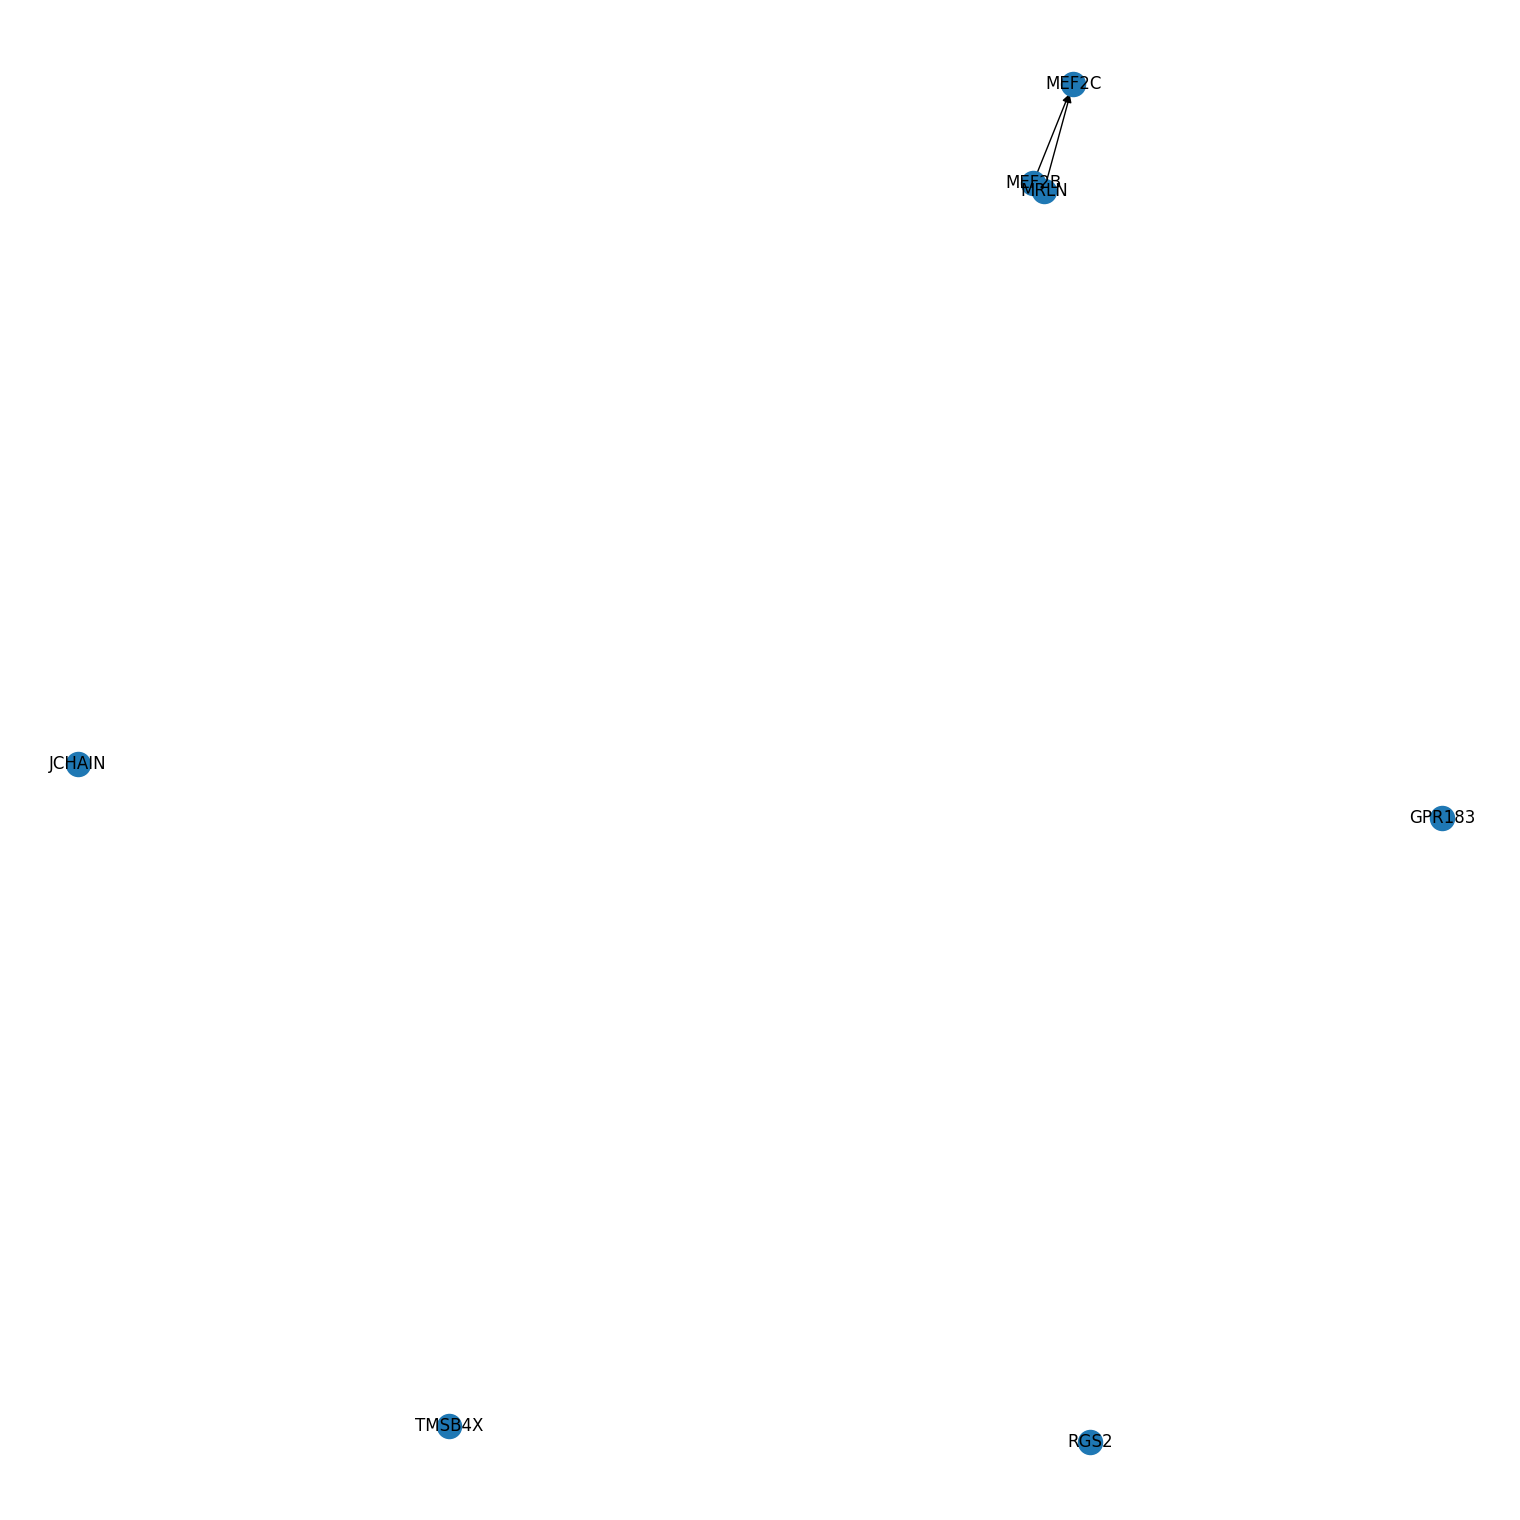

In [ ]:
gt_inter.plot_subgraph(
    ["MEF2C", "TMSB4X", "GPR183", "JCHAIN", "RGS2", "MRLN", "MEF2B"],
    max_genes=20,
    interactive=False,
)

In [ ]:
humaninter[humaninter["Name1"] == "GPR183"]

,Protein1,Protein2,Name1,Name2,confidence_level,RFprob,AFprob,CFprob,AFMprob,PDBtemp,NconfDBs,NallDBs,STRING,Known1,Known2,Count1,Count2,Locality1,Locality2,More_names1,More_names2,Disease1,Disease2,Process1,Process2,Function1,Function2,confDBs,allDBs,Exact_templates,Ortho_templates,Homo_templates
1550,P32249,Q86YT9,GPR183,JAML,high,0.2827,0.901,0.764,0.597,none,1,1,199,14.1,9.9,11,5,"Cell membrane,Membrane","Cell junction,Cell membrane,Membrane",none,none,none,none,"Adaptive immunity,Immunity","Cell adhesion,Immunity",G-protein coupled receptor 183,Junctional adhesion molecule-like,none,none,none,none,none


In [43]:
humaninter[humaninter["Name1"].isin(h1[:2])].head(60)

,Protein1,Protein2,Name1,Name2,confidence_level,RFprob,AFprob,CFprob,AFMprob,PDBtemp,NconfDBs,NallDBs,STRING,Known1,Known2,Count1,Count2,Locality1,Locality2,More_names1,More_names2,Disease1,Disease2,Process1,Process2,Function1,Function2,confDBs,allDBs,Exact_templates,Ortho_templates,Homo_templates
6473,Q06413,Q9UKV0,MEF2C,HDAC9,high,0.1040,0.94730,0.7495,0.9717,homolog,2,3,898,65.1,21.1,17,12,"Cytoplasm,Nucleus",Nucleus,none,none,"Disease variant,Epilepsy,Intellectual disability",none,"Apoptosis,Differentiation,Neurogenesis,Transcr...","Transcription,Transcription regulation",Myocyte-specific enhancer factor 2C,Histone deacetylase 9,"BIOGRID,UNIPROT","STRING,BIOGRID,UNIPROT",none,none,"1tqe,7xuz"
9146,P62979,Q9Y3U8,RPS27A,RPL36,moderate,0.6430,0.52500,0.6490,0.0000,none,1,1,649,7.7,5.9,20,0,"Cytoplasm,Nucleus",Cytoplasm,none,none,none,none,none,none,Ubiquitin-ribosomal protein eS31 fusion protein,Large ribosomal subunit protein eL36,none,STRING,none,none,none
13934,Q06413,Q8WX93,MEF2C,PALLD,high,0.3926,0.96970,0.9585,0.8740,none,1,1,0,65.1,3.5,17,16,"Cytoplasm,Nucleus","Cell junction,Cell projection,Cytoplasm,Cytosk...",none,none,"Disease variant,Epilepsy,Intellectual disability",none,"Apoptosis,Differentiation,Neurogenesis,Transcr...",none,Myocyte-specific enhancer factor 2C,Palladin,none,none,none,none,none
23146,P62979,Q5JVS0,RPS27A,HABP4,high,0.8330,0.03723,0.6313,0.9660,none,1,1,343,7.7,7.5,20,10,"Cytoplasm,Nucleus","Cytoplasm,Nucleus",none,none,none,none,none,"mRNA processing,mRNA splicing,Transcription,Tr...",Ubiquitin-ribosomal protein eS31 fusion protein,Intracellular hyaluronan-binding protein 4,none,STRING,none,none,none
28163,P62979,Q8NC51,RPS27A,SERBP1,high,0.9175,0.98200,0.9956,0.9770,none,1,1,343,7.7,7.7,20,9,"Cytoplasm,Nucleus","Cytoplasm,Nucleus",none,none,none,none,none,Translation regulation,Ubiquitin-ribosomal protein eS31 fusion protein,SERPINE1 mRNA-binding protein 1,none,STRING,none,none,none


In [ ]:
BenGRN(grn).compare_to(gt_cm)